## CS 476 Assignment 4
#### Jeongseop Yi (Patrick), j22yi
#### Q1

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### a)

In [2]:
# butterfly option payoff function
def butterflyPayoff(S, K1, K3):
    K2 = (K1 + K3) / 2
    if np.isnan(S):
        return np.nan
    if S > K1 and S < K2:
        return S - K1
    elif S > K2 and S < K3:
        return K3 - S
    else:
        return 0

# sigma function
def sigma_func(S, alpha):
    return np.divide(alpha, np.sqrt(S), out=np.zeros_like(S), where=S!=0)

In [3]:
# upstream alpha beta calculation function
def upstream(S, sigma_func, r):
    Splus1 = np.roll(S, -1)
    Splus1[-1] = np.nan
    Sminus1 = np.roll(S, 1)
    Sminus1[0] = np.nan
    sigma = sigma_func(S)

    alpha_cen = (sigma**2*S**2 / ((S - Sminus1) * (Splus1 - Sminus1)) 
                 - (r * S) / (Splus1 - Sminus1))
    beta_cen = (sigma**2*S**2 / ((Splus1 - S) * (Splus1 - Sminus1)) 
                + (r * S) / (Splus1 - Sminus1))
    alpha_cen = np.nan_to_num(alpha_cen, copy=False)
    beta_cen = np.nan_to_num(beta_cen, copy=False)

    alpha_ret = np.zeros(len(S))
    beta_ret = np.zeros(len(S))
    for i in range(len(S)):
        if (alpha_cen[i] >= 0 and beta_cen[i] >= 0):
            alpha_ret[i] = alpha_cen[i]
            beta_ret[i] = beta_cen[i]
        else:
            alpha_for = np.nan_to_num(sigma[i]**2*S[i]**2 / 
                                      ((S[i] - Sminus1[i]) * (Splus1[i] - Sminus1[i])))
            beta_for = np.nan_to_num(sigma[i]**2*S[i]**2 / 
                                     ((Splus1[i] - S[i]) * (Splus1[i] - Sminus1[i])) 
                                     + (r * S[i]) / (Splus1[i] - Sminus1[i]))
            if (alpha_for >= 0 and beta_for >= 0):
                alpha_ret[i] = alpha_for
                beta_ret[i] = beta_for
            else:
                alpha_ret[i] = np.nan_to_num(sigma[i]**2*S[i]**2 / 
                                             ((S[i] - Sminus1[i]) * 
                                              (Splus1[i] - Sminus1[i])))
                beta_ret[i] = np.nan_to_num(sigma[i]**2*S[i]**2 / 
                                            ((Splus1[i] - S[i]) * 
                                             (Splus1[i] - Sminus1[i])) 
                                            + (r * S[i]) / (Splus1[i] - Sminus1[i]))
    return alpha_ret, beta_ret

In [4]:
# PDE function for implicit, 
# Crank-Nicolson and CN-Rannacher extrapolation
def implicit_CN(S, payoff, sigma, r, T, dt, CN, RN=False):
    N = int(T / dt)
    V = np.zeros((N + 1, len(S)))
    V[0] = list(map(lambda x: payoff(x), S))
    for i in range(N):
        alpha, beta = upstream(S, sigma, r)
        M = [[], [], []]
        M[0] = -alpha*dt
        M[1] = (alpha + beta + r)*dt
        M[2] = -beta*dt
        M[0] = M[0][1:]
        M[2] = M[2][:len(S)-1]
        
        theta = 0
        if (CN):
            theta = 0.5
        elif (RN):
            if (i >= 2):
                theta = 0.5
            else:
                theta = 0

        Mdiag = sp.sparse.diags(M, [-1, 0, 1], format='csr')
        M1 = sp.sparse.eye(len(S)) + (Mdiag * (1 - theta))
        M2 = sp.sparse.eye(len(S)) - (Mdiag * theta)
        vi = M2 @ V[i]

        V[i+1] = sp.sparse.linalg.spsolve(M1, vi)
    return V


In [5]:
# helper function to refine the stock price grid
def double_S(S):
    SS = S.repeat(2)
    return (SS[1:] + SS[:-1]) / 2

# helper function to find the correct index
def index1(x):
    return int(np.log(x // 25) / np.log(2))

# helper function to find 
# the correct index of the stock price index
def index2(k, x):
    idx = index1(x)
    return k * 2 ** idx - 1 * 2 ** idx

In [6]:
# parameters from Table 1
S0 = 95
K1 = 0.9 * S0
K3 = 1.1 * S0
r = 0.05
alpha = 2.5
T = 1

S = np.concatenate([
    np.arange(0, 0.45*S0, 0.1*S0),
    np.arange(0.45*S0, 0.82*S0, 0.05*S0),
    np.arange(0.82*S0, 0.91*S0, 0.02*S0),
    np.arange(0.91*S0, 1.105*S0, 0.01*S0),
    np.arange(1.12*S0, 1.21*S0, 0.02*S0),
    np.arange(1.25*S0, 1.62*S0, 0.05*S0),
    np.arange(1.7*S0, 2.05*S0, 0.1*S0),
    np.array([2.2*S0, 2.4*S0, 2.8*S0, 3.6*S0, 5*S0, 7.5*S0, 10*S0]),
])

In [14]:
# create a dataframe to store the convergence results
conv_test1 = {'n': [25], 'len': [len(S)]}
conv_test2 = {'n': [25], 'len': [len(S)]}
conv_test3 = {'n': [25], 'len': [len(S)]}

S_list = [S]
for i in range(1, 7):
    conv_test1['n'].append(2 ** i * 25)
    conv_test1['len'].append(len(SS))
    conv_test2['n'].append(2 ** i * 25)
    conv_test2['len'].append(len(SS))
    conv_test3['n'].append(2 ** i * 25)
    conv_test3['len'].append(len(SS))
    SS = double_S(S_list[i-1])
    S_list.append(SS)

conv_test1 = pd.DataFrame(conv_test1)
conv_test2 = pd.DataFrame(conv_test2)
conv_test3 = pd.DataFrame(conv_test3)

##################################
# Implicit
##################################
conv_test1['Dt'] = T / conv_test1['n']
conv_test1['Imp'] = conv_test1['n'].apply(
    lambda x: implicit_CN(S_list[index1(x)], 
                          lambda S: butterflyPayoff(S, K1, K3), 
                          lambda S: sigma_func(S, alpha), r, T, T/x, False)
                          [-1][index2(28, x)])
conv_test1['Imp_Change'] = conv_test1['Imp'].diff()
conv_test1['Imp_Ratio'] = conv_test1['Imp_Change'].shift(1) \
    / conv_test1['Imp_Change']

##################################
# Crank-Nicolson
##################################
conv_test2['Dt'] = T / conv_test2['n']
conv_test2['CN'] = conv_test2['n'].apply(
    lambda x: implicit_CN(S_list[index1(x)], 
                          lambda S: butterflyPayoff(S, K1, K3), 
                          lambda S: sigma_func(S, alpha), r, T, T/x, True)
                          [-1][index2(28, x)])
conv_test2['CN_Change'] = conv_test2['CN'].diff()
conv_test2['CN_Ratio'] = conv_test2['CN_Change'].shift(1) \
    / conv_test2['CN_Change']

##################################
# Crank-Nicolson Rannacher
##################################
conv_test3['Dt'] = T / conv_test3['n']
conv_test3['CNR'] = conv_test3['n'].apply(
    lambda x: implicit_CN(S_list[index1(x)], 
                          lambda S: butterflyPayoff(S, K1, K3), 
                          lambda S: sigma_func(S, alpha), r, T, T/x, False, True)
                          [-1][index2(28, x)])
conv_test3['CNR_Change'] = conv_test3['CNR'].diff()
conv_test3['CNR_Ratio'] = conv_test3['CNR_Change'].shift(1) \
    / conv_test3['CNR_Change']

# show the results
display(conv_test1)
display(conv_test2)
display(conv_test3)

,n,len,Dt,Imp,Imp_Change,Imp_Ratio
0,25,62,0.040000,1.374408,NaN,NaN
1,50,3905,0.020000,1.364618,-0.009790,NaN
2,100,123,0.010000,1.359465,-0.005153,1.899849
3,200,245,0.005000,1.356833,-0.002631,1.958268
4,400,489,0.002500,1.355505,-0.001328,1.980869
5,800,977,0.001250,1.354838,-0.000667,1.990827
6,1600,1953,0.000625,1.354503,-0.000334,1.995508


,n,len,Dt,CN,CN_Change,CN_Ratio
0,25,62,0.040000,1.323363,NaN,NaN
1,50,3905,0.020000,1.368264,0.044901,NaN
2,100,123,0.010000,1.361329,-0.006935,-6.474455
3,200,245,0.005000,1.357776,-0.003553,1.952047
4,400,489,0.002500,1.355979,-0.001797,1.976968
5,800,977,0.001250,1.355075,-0.000904,1.988682
6,1600,1953,0.000625,1.354622,-0.000453,1.994387


,n,len,Dt,CNR,CNR_Change,CNR_Ratio
0,25,62,0.040000,1.354001,NaN,NaN
1,50,3905,0.020000,1.354154,1.532781e-04,NaN
2,100,123,0.010000,1.354166,1.202070e-05,12.751173
3,200,245,0.005000,1.354168,1.623560e-06,7.403916
4,400,489,0.002500,1.354168,2.651008e-07,6.124313
5,800,977,0.001250,1.354168,5.055550e-08,5.243758
6,1600,1953,0.000625,1.354168,1.100084e-08,4.595604


Yes, the observations are consistent with the theory regarding the rate of convergence.

The values from the implicit method and Crank-Nicolson method show linear convergence where the ratio is around 2.

The values from the CN-Rannacher method show quadratic convergence as expected where the ratio is around 4.

#### b)

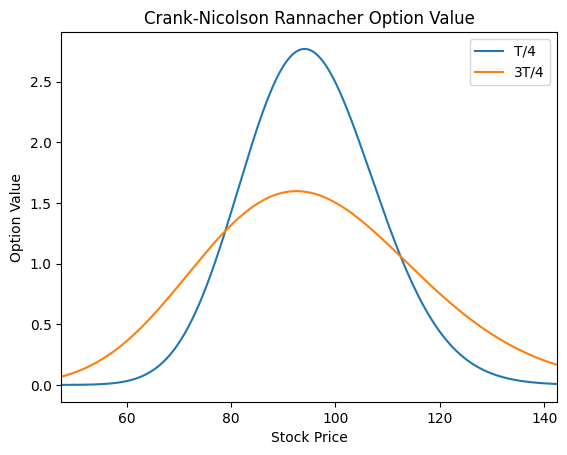

In [8]:
N = conv_test1['n'].iloc[-1]

V_ran = implicit_CN(S_list[-1], 
                    lambda S: butterflyPayoff(S, K1, K3), 
                    lambda S: sigma_func(S, alpha), 
                    r, T, T/N, False, True)
ax = sns.lineplot(x=S_list[-1], y=V_ran[N // 4], label='T/4')
sns.lineplot(x=S_list[-1], y=V_ran[N // 4 * 3], label='3T/4')
ax.set_xlim(0.5 * S0, 1.5 * S0)
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.title('Crank-Nicolson Rannacher Option Value')
plt.show()

As time passes, the curve of the option value becomes more platykurtic. This is possibly due to the increase of the probability of a stock price becoming profitable by the butterfly payoff as time increases (in PDE, we go backwards in time, so there are more time left to maturity when t is bigger).

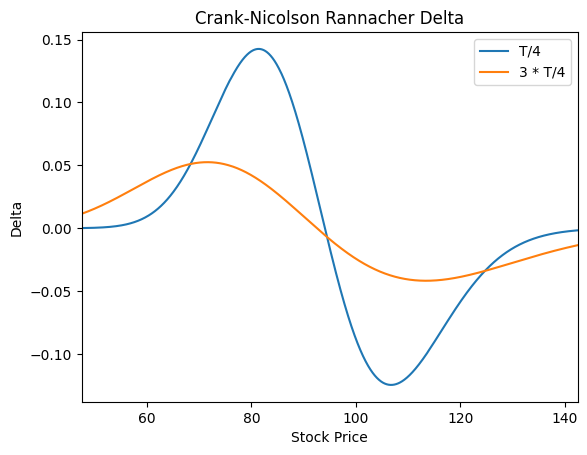

In [9]:
# delta of the V_ran
delta_V_ran = np.zeros((len(V_ran), len(S_list[-1])))
for i in range(len(V_ran)):
    V_ran_i_s = np.roll(V_ran[i-1], -1)
    V_ran_i_s[-1] = 0
    Ss = np.roll(S_list[-1], -1)
    Ss[-1] = 0
    delta_V_ran[i] = (V_ran_i_s - V_ran[i-1]) / (Ss - S_list[-1])
ax = sns.lineplot(x=S_list[-1], y=delta_V_ran[N // 4], label='T/4')
sns.lineplot(x=S_list[-1], y=delta_V_ran[3 * N // 4], label='3 * T/4')
ax.set_xlim(0.5 * S0, 1.5 * S0)
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Crank-Nicolson Rannacher Delta')
plt.show()

The delta graphs also become flat as the time increases. As the option value graph becomes platykurtic as the time increases, the absolute value (or magnitude) of delta (or change) in the option value also decreases.

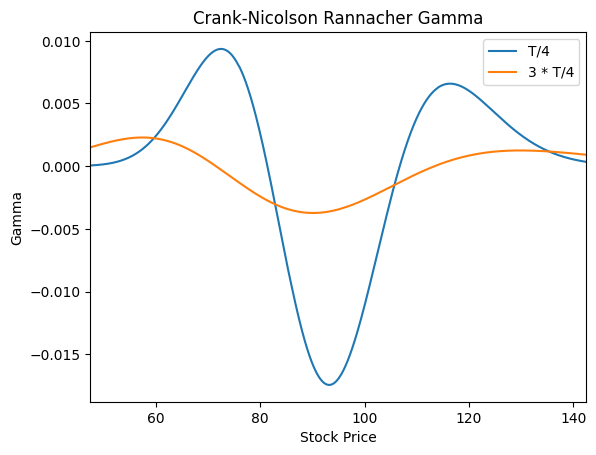

In [10]:
# gamma of the V_ran
gamma_V_ran = np.zeros((len(V_ran), len(S_list[-1])))
for i in range(len(V_ran)):
    G_ran_i_s = np.roll(delta_V_ran[i-1], -1)
    Ss1 = np.roll(S_list[-1], -1)
    Ss2 = np.roll(S_list[-1], 0)
    diff = Ss1 - Ss2
    diff_avg = (diff + np.roll(diff, -1)) / 2
    gamma_V_ran[i] = (G_ran_i_s - delta_V_ran[i-1]) / diff_avg

ax = sns.lineplot(x=S_list[-1], y=gamma_V_ran[N // 4], label='T/4')
sns.lineplot(x=S_list[-1], y=gamma_V_ran[3 * N // 4], label='3 * T/4')
ax.set_xlim(0.5 * S0, 1.5 * S0)
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Crank-Nicolson Rannacher Gamma')
plt.show()

To prevent the spikes from occuring from the difference in distance in the stock price matrix, the average of the nearby difference is taken to calculate the gamma.

Similarly with value and delta graph, the graph becomes flat as the time increases. The reason is the flatness of the delta graph as explained above.